# import library

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import json
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import os

# connect to mysql

In [2]:
with open('config.json') as f:
    config = json.load(f)

db_config = config['database']
username = db_config['user']
password = db_config['password']
host = db_config['host']
database = db_config['name']
password_encoded = quote_plus(password)

engine = create_engine(f"mysql+pymysql://{username}:{password_encoded}@{host}/{database}")

# import option

In [3]:
pd.set_option('display.max_columns', None)

# Import DataSet

In [4]:
df_retail = pd.read_csv("Online Retail.csv")

# check dataset

In [5]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# renaming column 

In [7]:
df_retail.rename(columns={
    "InvoiceNo" : "Invoice_No" ,    
    "StockCode" : "Stock_Code",    
    "InvoiceDate" : "Invoice_Date",  
    "UnitPrice" : "Unit_Price",    
    "CustomerID" : "Customer_ID"  
},inplace=True)

# check null value

In [8]:
df_retail.isnull().sum()

Invoice_No           0
Stock_Code           0
Description       1454
Quantity             0
Invoice_Date         0
Unit_Price           0
Customer_ID     135080
Country              0
dtype: int64

In [9]:
df_retail.isnull().mean()*100

Invoice_No       0.000000
Stock_Code       0.000000
Description      0.268311
Quantity         0.000000
Invoice_Date     0.000000
Unit_Price       0.000000
Customer_ID     24.926694
Country          0.000000
dtype: float64

In [10]:
df_retail["Customer_ID"] = df_retail["Customer_ID"].fillna(0)
df_retail["Description"] = df_retail["Description"].fillna("Unknown")

In [11]:
df_retail.isnull().sum()

Invoice_No      0
Stock_Code      0
Description     0
Quantity        0
Invoice_Date    0
Unit_Price      0
Customer_ID     0
Country         0
dtype: int64

# data type

In [12]:
df_retail.dtypes

Invoice_No       object
Stock_Code       object
Description      object
Quantity          int64
Invoice_Date     object
Unit_Price      float64
Customer_ID     float64
Country          object
dtype: object

In [13]:
df_retail.head()

,Invoice_No,Stock_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [14]:
# remove every character in this var
df_retail['Invoice_No'] = df_retail['Invoice_No'].str.replace(r'\D+', '', regex=True)

In [15]:
df_retail = df_retail.astype({
    "Invoice_No":"int",
    "Customer_ID":"int"
})

In [16]:
df_retail["Invoice_Date"] = pd.to_datetime(df_retail["Invoice_Date"])

In [17]:
df_retail.dtypes

Invoice_No               int32
Stock_Code              object
Description             object
Quantity                 int64
Invoice_Date    datetime64[ns]
Unit_Price             float64
Customer_ID              int32
Country                 object
dtype: object

# get additional column 

In [18]:
df_retail['Year'] = df_retail['Invoice_Date'].dt.year
df_retail['Month'] = df_retail['Invoice_Date'].dt.month
df_retail['Day'] = df_retail['Invoice_Date'].dt.day
df_retail['Hour'] = df_retail['Invoice_Date'].dt.hour
df_retail['Minute'] = df_retail['Invoice_Date'].dt.minute
df_retail['Weekday'] = df_retail['Invoice_Date'].dt.day_name() 

In [19]:
df_retail["Total_Price"] = df_retail["Quantity"] * df_retail["Unit_Price"]

In [20]:
df_retail.to_csv('df_retail_code.csv', index=False, encoding='utf-8')

# Normalize

In [21]:
numeric_cols = ['Quantity', 'Unit_Price','Total_Price']

# normalize 
scaler = StandardScaler()
scaled  = scaler.fit_transform(df_retail[numeric_cols])

#create a dataframe becouse doesnt remove data
scaled_df = pd.DataFrame(scaled, columns=['Quantity_scaled', 'UnitPrice_scaled','Total_Price_scaled'])

#add to orginal dataframe
df_retail = pd.concat([df_retail, scaled_df], axis=1)

#delete additional data
del scaled_df , scaled ,scaler

# visioulation

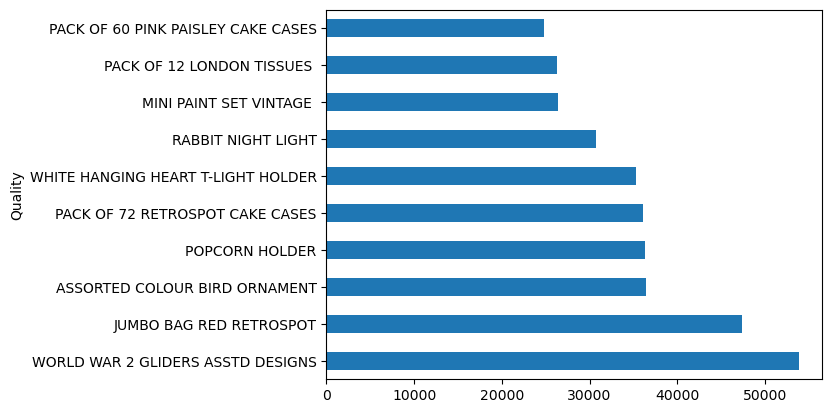

In [22]:
top_10_products_by_quantity = df_retail.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
top_10_products_by_quantity.plot(kind="barh",ylabel="Quality")
plt.show()
del top_10_products_by_quantity

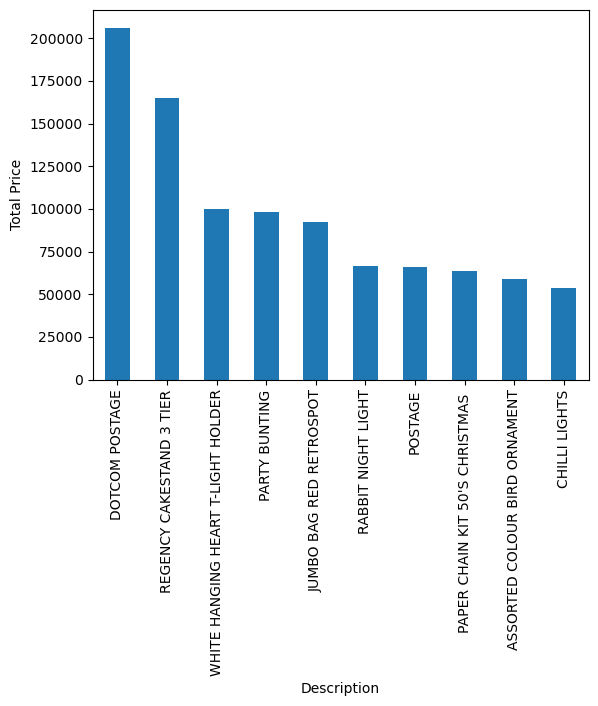

In [23]:
top_10_products_by_sales = df_retail.groupby("Description")["Total_Price"].sum().sort_values(ascending=False).head(10)
top_10_products_by_sales.plot(kind="bar",ylabel="Total Price")
plt.show()
del top_10_products_by_sales

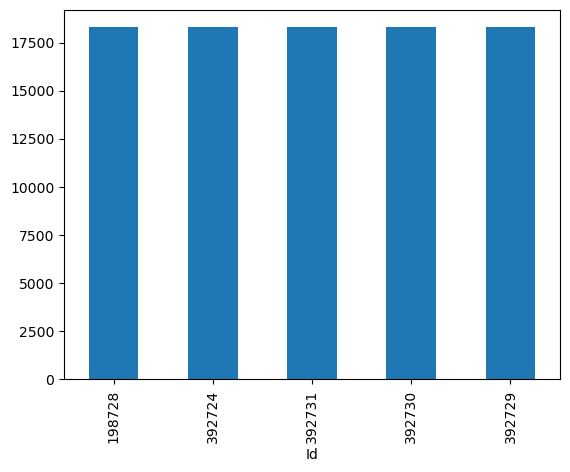

In [24]:
top_customer_id=df_retail['Customer_ID'].sort_values(ascending=False).head()
top_customer_id.plot(kind="bar",xlabel="Id")
plt.show()

# separate colum

In [25]:
# splitting every world of the Description data column
description = df_retail["Description"].str.split(" ", expand=True)
# fill none column
description = description.fillna("-")
# name of the column 
description.columns = [f'Desc_Token_{i}' for i in range(description.shape[1])]
# add to orginal column
df_retail = pd.concat([df_retail.reset_index(drop=True), description.reset_index(drop=True)], axis=1)

del description 

# fpgrowth algorithm

In [26]:
def run_market_basket(df, cols, min_support=0.01, metric="lift", min_threshold=1):
    # we need quantity > 0
    df_filtered = df[df["Quantity"] > 0]
    
    # sell basket
    basket = df_filtered.groupby(cols)["Quantity"].sum().unstack().fillna(0)
    basket = (basket > 0).astype(int)

    # extract favorite product
    frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)

    #generate rules
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)

    return frequent_itemsets, rules

In [27]:
frequent_itemsets_InvoiceNo, rules_InvoiceNo = run_market_basket(df_retail, ['Invoice_No', 'Stock_Code'], min_support=0.02)

c:\Users\aliaj\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


benefit rule

In [28]:
strong_rules_InvoiceNo = rules_InvoiceNo[(rules_InvoiceNo['confidence'] > 0.5) & (rules_InvoiceNo['lift'] > 1.2)]
strong_rules_InvoiceNo.sort_values(by='lift', ascending=False,inplace=True)
strong_rules_InvoiceNo.head()

C:\Users\aliaj\AppData\Local\Temp\ipykernel_11504\518113049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_rules_InvoiceNo.sort_values(by='lift', ascending=False,inplace=True)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
130,(22698),"(22699, 22697)",0.036955,0.037051,0.026148,0.707572,19.097068,1.0,0.024779,3.292941,0.983999,0.546371,0.696320,0.706650
127,"(22699, 22697)",(22698),0.037051,0.036955,0.026148,0.705729,19.097068,1.0,0.024779,3.272649,0.984098,0.546371,0.694437,0.706650
131,(22697),"(22699, 22698)",0.048968,0.028898,0.026148,0.533990,18.478377,1.0,0.024733,2.083866,0.994585,0.505597,0.520123,0.719416
126,"(22699, 22698)",(22697),0.028898,0.048968,0.026148,0.904841,18.478377,1.0,0.024733,9.994183,0.974030,0.505597,0.899942,0.719416
122,(22698),(22697),0.036955,0.048968,0.030538,0.826371,16.875875,1.0,0.028729,5.477375,0.976843,0.551394,0.817431,0.725008


visoulation rules

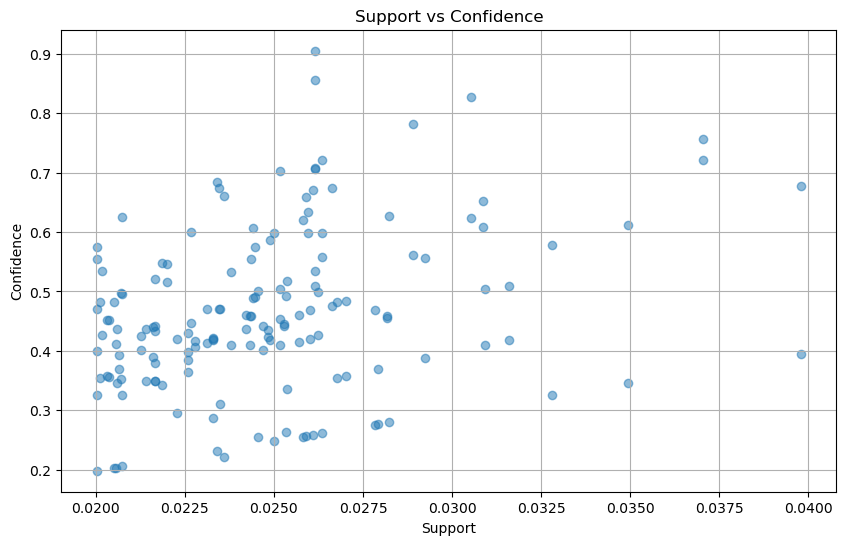

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(rules_InvoiceNo['support'], rules_InvoiceNo['confidence'], alpha=0.5)
plt.title("Support vs Confidence")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.grid(True)
plt.show()

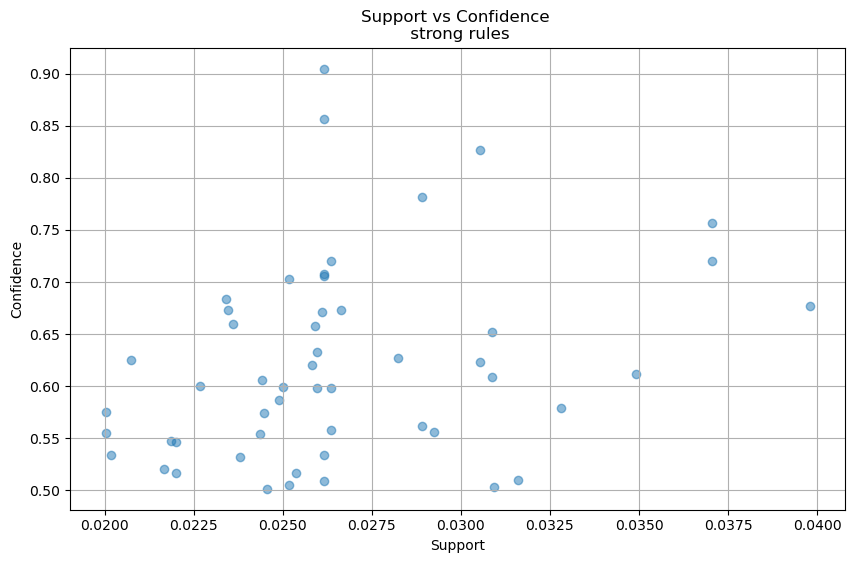

In [30]:
plt.figure(figsize=(10,6))
plt.scatter(strong_rules_InvoiceNo['support'], strong_rules_InvoiceNo['confidence'], alpha=0.5)
plt.title("Support vs Confidence \n strong rules")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.grid(True)
plt.show()

# show diagram

In [31]:
def categorize_rule(row):
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    if (len(antecedents) == 1) and (len(consequents) == 1):
        return 'Cross-sell'
    
    elif (len(antecedents) > 1) and (len(consequents) == 1):
        return 'Bundling'
    
    elif (len(antecedents) == 1) and (len(consequents) > 1):
        return 'Combo Discount'
    
    else:
        return 'Complex Rule'

In [32]:
rules_InvoiceNo['Strategy'] = rules_InvoiceNo.apply(categorize_rule, axis=1)

In [33]:
cross_sell_rules = rules_InvoiceNo[rules_InvoiceNo['Strategy'] == 'Cross-sell']
bundling_rules = rules_InvoiceNo[rules_InvoiceNo['Strategy'] == 'Bundling']
combo_discount_rules = rules_InvoiceNo[rules_InvoiceNo['Strategy'] == 'Combo Discount']

In [34]:
# pivote table
def prepare_rules_for_pivot(rules_df, strategy_name):
    df = rules_df[['antecedents', 'consequents', 'confidence', 'lift']].copy()
    df['Strategy'] = strategy_name
    return df


In [35]:
combo_discount_pivot = prepare_rules_for_pivot(combo_discount_rules, 'Combo Discount')
bundling_pivot = prepare_rules_for_pivot(bundling_rules, 'Bundling')
cross_sell_pivot = prepare_rules_for_pivot(cross_sell_rules, 'Cross-sell')

contact pivot table

In [36]:
rules_pivot = pd.concat([combo_discount_pivot, bundling_pivot, cross_sell_pivot], ignore_index=True)

del combo_discount_pivot,bundling_pivot,cross_sell_pivot

rules_pivot.head()


,antecedents,consequents,confidence,lift,Strategy
0,(22699),"(22698, 22697)",0.508443,16.649292,Combo Discount
1,(22698),"(22699, 22697)",0.707572,19.097068,Combo Discount
2,(22697),"(22699, 22698)",0.533990,18.478377,Combo Discount
3,"(22699, 22698)",(22697),0.904841,18.478377,Bundling
4,"(22699, 22697)",(22698),0.705729,19.097068,Bundling


# encoding

In [37]:
#splite world of the text
description = df_retail["Description"].str.split(" ", expand=True)
#fill none item
description = description.fillna("-")
# all data in one column
all_words = pd.Series(description.values.ravel())  
# remove Duplicate data
all_words = all_words.dropna().unique()

In [38]:
label_encode = LabelEncoder()
encoded_words = label_encode.fit_transform(all_words)

word_encoding_map = dict(zip(all_words, encoded_words))
description_encoded = description.applymap(lambda x: word_encoding_map.get(x) if x in word_encoding_map else None)

# column name change
description_encoded.columns = [f'Encoding_Token_{i}' for i in range(description_encoded.shape[1])]

#add to orginal dataset
df_retail_encoded = pd.concat([df_retail.reset_index(drop=True), description_encoded.reset_index(drop=True)], axis=1)

del label_encode,word_encoding_map,description_encoded


C:\Users\aliaj\AppData\Local\Temp\ipykernel_11504\4037476988.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  description_encoded = description.applymap(lambda x: word_encoding_map.get(x) if x in word_encoding_map else None)


# save dataframe

In [39]:
os.makedirs('database_exports', exist_ok=True)

In [40]:
database = 'dataset_retail'

datasets = {
    'Total_Data': df_retail,
    'Encoder': df_retail_encoded.loc[:, ~df_retail_encoded.columns.duplicated()],
    'Rules': rules_pivot
}

with open("database_exports/dataset_retail.db", "w", encoding='utf-8') as f:
    
    f.write(f"CREATE DATABASE IF NOT EXISTS `{database}`;\n")
    f.write(f"USE `{database}`;\n\n")

    for table_name, df in datasets.items():
        f.write(f"DROP TABLE IF EXISTS `{table_name}`;\n")
        
        table_creation_sql = pd.io.sql.get_schema(df, table_name, con=engine)
        f.write(table_creation_sql + ";\n\n")
        
        for index, row in df.iterrows():
            values = []
            for value in row.values:
                if pd.notna(value):
                    clean_value = str(value).replace("'", "''")
                    values.append(f"'{clean_value}'")
                else:
                    values.append('NULL')
            values_joined = ", ".join(values)
            f.write(f"INSERT INTO `{table_name}` VALUES ({values_joined});\n")
        
        f.write("\n\n")  

engine.dispose()


In [41]:
df_retail.head()

,Invoice_No,Stock_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Year,Month,Day,Hour,Minute,Weekday,Total_Price,Quantity_scaled,UnitPrice_scaled,Total_Price_scaled,Desc_Token_0,Desc_Token_1,Desc_Token_2,Desc_Token_3,Desc_Token_4,Desc_Token_5,Desc_Token_6,Desc_Token_7,Desc_Token_8,Desc_Token_9
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,8,26,Wednesday,15.30,-0.016289,-0.021301,-0.007095,WHITE,HANGING,HEART,T-LIGHT,HOLDER,-,-,-,-,-
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,8,26,Wednesday,20.34,-0.016289,-0.012620,0.006209,WHITE,METAL,LANTERN,-,-,-,-,-,-,-
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,8,26,Wednesday,22.00,-0.007118,-0.019234,0.010592,CREAM,CUPID,HEARTS,COAT,HANGER,-,-,-,-,-
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,8,26,Wednesday,20.34,-0.016289,-0.012620,0.006209,KNITTED,UNION,FLAG,HOT,WATER,BOTTLE,-,-,-,-
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,8,26,Wednesday,20.34,-0.016289,-0.012620,0.006209,RED,WOOLLY,HOTTIE,WHITE,HEART.,-,-,-,-,-


In [42]:
df_retail_encoded.to_csv('df_retail_encoded.csv', index=False, encoding='utf-8')
df.to_csv('market_basket_rules.csv', index=False, encoding='utf-8')
rules_pivot.to_csv('rules_pivot.csv', index=False, encoding='utf-8')